In [218]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import datetime
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn import linear_model
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
import time

%load_ext autoreload
%autoreload 2
from functions import *
from plots import *

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8  # plotsize 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import Seasonal Data

In [219]:
df_seas1 = pd.DataFrame.from_csv('../data_ski_in_solitude/combined_data/combined_11_12.csv')
df_seas2 = pd.DataFrame.from_csv('../data_ski_in_solitude/combined_data/combined_12_13.csv')
df_seas3 = pd.DataFrame.from_csv('../data_ski_in_solitude/combined_data/combined_13_14.csv')
df_seas4 = pd.DataFrame.from_csv('../data_ski_in_solitude/combined_data/combined_14_15.csv')
df_seas5 = pd.DataFrame.from_csv('../data_ski_in_solitude/combined_data/combined_15_16.csv')

In [220]:
df_seas5.tail()

,away_WP,to_WP,day_of_week,skiers,new_24,basedepth,open_trails,open_lifts,open_percent,tot_snow,week_snow_tot,2day_snow_tot,3day_snow_tot,4day_snow_tot,5day_snow_tot,6day_snow_tot
date,,,,,,,,,,,,,,,,
2016-04-22,NaN,NaN,NaN,NaN,1.4,63.5,67.0,6.5,48.5,279.7,9.8,2.8,4.2,5.6,7,8.4
2016-04-23,NaN,NaN,NaN,NaN,1.4,76.5,105.5,9.0,74.0,281.1,9.8,2.8,4.2,5.6,7,8.4
2016-04-24,NaN,NaN,NaN,NaN,1.4,83.0,104.5,9.0,73.5,282.5,9.8,2.8,4.2,5.6,7,8.4
2016-04-25,NaN,NaN,NaN,NaN,1.4,73.5,99.0,9.0,69.5,283.9,9.8,2.8,4.2,5.6,7,8.4
2016-04-26,NaN,NaN,NaN,NaN,1.4,74.5,96.0,9.0,67.5,285.3,9.8,2.8,4.2,5.6,7,8.4


In [221]:
seas_list = [df_seas1, df_seas2, df_seas3, df_seas4, df_seas5]

In [222]:
for season in seas_list:
    if type(season.day_of_week) != int:
        season_list = day_of_week_col(season)

In [223]:
df_seas5.tail()

,away_WP,to_WP,day_of_week,skiers,new_24,basedepth,open_trails,open_lifts,open_percent,tot_snow,week_snow_tot,2day_snow_tot,3day_snow_tot,4day_snow_tot,5day_snow_tot,6day_snow_tot
date,,,,,,,,,,,,,,,,
2016-04-22,NaN,NaN,4,NaN,1.4,63.5,67.0,6.5,48.5,279.7,9.8,2.8,4.2,5.6,7,8.4
2016-04-23,NaN,NaN,5,NaN,1.4,76.5,105.5,9.0,74.0,281.1,9.8,2.8,4.2,5.6,7,8.4
2016-04-24,NaN,NaN,6,NaN,1.4,83.0,104.5,9.0,73.5,282.5,9.8,2.8,4.2,5.6,7,8.4
2016-04-25,NaN,NaN,0,NaN,1.4,73.5,99.0,9.0,69.5,283.9,9.8,2.8,4.2,5.6,7,8.4
2016-04-26,NaN,NaN,1,NaN,1.4,74.5,96.0,9.0,67.5,285.3,9.8,2.8,4.2,5.6,7,8.4


#### Create dummy variables for days of the week.

In [224]:
seas_list = [pd.concat([season,  pd.get_dummies(season.day_of_week, prefix='day')], axis=1) for season in seas_list]

#### Make midweek column

In [225]:
seas_list = [make_midweek_col(season) for season in seas_list]

#### Make month column

In [226]:
for season in seas_list:
    season['month'] = season.index.month 

#### Make monthly dummy variables and drop month column

In [227]:
seas_list = [pd.concat([season, pd.get_dummies(season.month, prefix='month')], axis=1) for season in seas_list]

In [228]:
seas_list = [season.drop(['day_1', 'day_2', 'day_3', 'day_of_week', 'month'], axis=1) for season in seas_list]

#### Create a 'days since beginning of season' feature

In [229]:
for count, season in enumerate(seas_list):
    row_num = []
    for i in range(1,len(seas_list[count])+1):
        row_num.append(i)
    seas_list[count]['days_since_start'] = row_num

#### Make holiday features

In [230]:
holiday_seas = [0]*5
count = 0
for season in seas_list:
    L = len(season)-1
    holiday_seas[count] = get_holiday_list(season.index[0].year, season.index[0].month, season.index[0].day, season.index[L].year, season.index[L].month, season.index[L].day)
    count += 1

In [231]:
vet_day = []
thanksgiv = []
xmas = []
mlk_day = []
pres_day = []
for i in range(0,len(holiday_seas)):
    vet_day, thanksgiv, xmas, mlk_day, pres_day = get_holiday_names(holiday_seas[i], vet_day, thanksgiv, xmas, mlk_day, pres_day)

In [232]:
vet_day

[Timestamp('2011-11-11 00:00:00'),
 Timestamp('2012-11-12 00:00:00'),
 Timestamp('2013-11-11 00:00:00'),
 Timestamp('2014-11-11 00:00:00'),
 Timestamp('2015-11-11 00:00:00')]

In [233]:
for count, season in enumerate(seas_list):
    seas_list[count] = call_make_holiday_columns(season, vet_day[count], thanksgiv[count], xmas[count], mlk_day[count], pres_day[count])

In [234]:
df_all = pd.concat([seas_list[0], seas_list[1], seas_list[2], seas_list[3], seas_list[4]], axis=0)

#### Create (holiday)(weekend) and (holiday)(fri/mon/weekday) features

In [235]:
df_all['before_xmas_sat'] = df_all.filter(regex="day_5")*df_all.before_xmas
df_all['pres_day_sat'] = df_all.filter(regex="day_5")*df_all.pres_day
df_all['xmas_sat'] = df_all.filter(regex="day_5")*df_all.xmas
df_all['mlk_sat'] = df_all.filter(regex="day_5")*df_all.mlk_day

df_all['before_xmas_sun'] = df_all.filter(regex="day_6")*df_all.before_xmas
df_all['pres_day_sun'] = df_all.filter(regex="day_6")*df_all.pres_day
df_all['xmas_sun'] = df_all.filter(regex="day_6")*df_all.xmas
df_all['mlk_sun'] = df_all.filter(regex="day_6")*df_all.mlk_day

df_all['before_xmas_fri'] = df_all.filter(regex="day_4")*df_all.before_xmas
df_all['pres_day_fri'] = df_all.filter(regex="day_4")*df_all.pres_day
df_all['xmas_fri'] = df_all.filter(regex="day_4")*df_all.xmas
df_all['mlk_fri'] = df_all.filter(regex="day_4")*df_all.mlk_day

df_all['before_xmas_mon'] = df_all.filter(regex="day_0")*df_all.before_xmas
df_all['pres_day_mon'] = df_all.filter(regex="day_0")*df_all.pres_day
df_all['xmas_mon'] = df_all.filter(regex="day_0")*df_all.xmas
df_all['mlk_mon'] = df_all.filter(regex="day_0")*df_all.mlk_day

### Make spring break column

In [236]:
df_all = make_spring_break_col(df_all)

#### Make squared, cubed, square root, and log features

In [237]:
def make_squared(df, features):
    for feat1 in features:
        df[feat1 + '_sq'] = df[feat1]**2
        df[feat1 + '_cu'] = df[feat1]**3
        df[feat1 + '_sqrt'] = np.sqrt(df[feat1])
        df['ln_' + feat1] = np.log(df[feat1])
    return df

In [238]:
features = list(df_all.columns.values)
leave_out = ['skiers', 'away_WP', 'to_WP', 'day_0', 'day_4', 'day_5', 'day_6', 'midweek', 'month_1', 'month_2',
             'month_3', 'month_4', 'month_11', 'month_12', 'vet_day', 'thanksgiv', 'xmas', 'mlk_day', 'pres_day',
             'xmas_sat', 'mlk_sat', 'xmas_sun', 'mlk_sun', 'xmas_fri', 'mlk_fri', 'xmas_mon', 'mlk_mon', 'spring_break', 
             'before_xmas', 'before_xmas_sat', 'pres_say_sat', 'before_xmas_sun', 'pres_say_sun', 'before_xmas_fri',
             'pres_say_fri', 'before_xmas_mon', 'pres_say_mon']
features = [f for f in features if f not in leave_out]
df_all = make_squared(df_all, features)

In [239]:
df_all.head()

,away_WP,to_WP,skiers,new_24,basedepth,open_trails,open_lifts,open_percent,tot_snow,week_snow_tot,...,pres_day_sun_sqrt,ln_pres_day_sun,pres_day_fri_sq,pres_day_fri_cu,pres_day_fri_sqrt,ln_pres_day_fri,pres_day_mon_sq,pres_day_mon_cu,pres_day_mon_sqrt,ln_pres_day_mon
2011-11-13,2882,1371,44,1,18,0,0,0,1,9.1,...,0,-inf,0,0,0,-inf,0,0,0,-inf
2011-11-14,1720,1607,-1467,1,18,0,0,0,4,9.1,...,0,-inf,0,0,0,-inf,0,0,0,-inf
2011-11-15,1539,1804,-1580,1,18,0,0,0,4,9.1,...,0,-inf,0,0,0,-inf,0,0,0,-inf
2011-11-16,1695,1808,-1315,1,18,0,0,0,5,9.1,...,0,-inf,0,0,0,-inf,0,0,0,-inf
2011-11-17,1890,1916,-1202,1,18,0,0,0,6,9.1,...,0,-inf,0,0,0,-inf,0,0,0,-inf


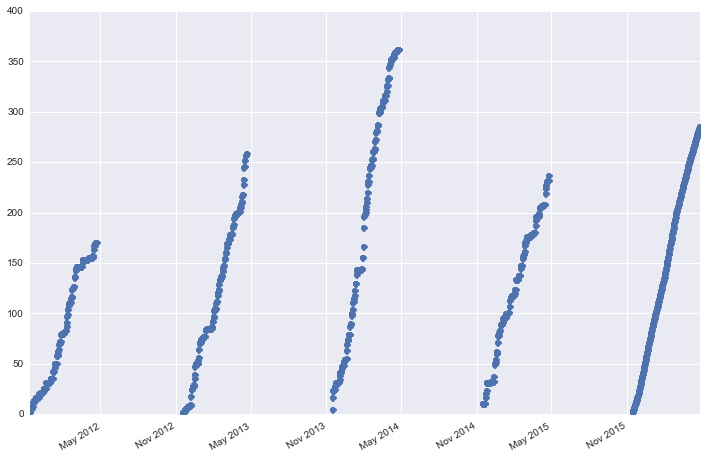

In [240]:
df_all.tot_snow.plot(linestyle='', marker='o')

# Export Data

In [241]:
df_all.to_csv('../data_ski_in_solitude/data_with_features/all_feat.csv')